# The quintic Ornstein-Uhlenbeck model VIX

In [1]:
import pandas as pd
import BlackScholes as bs
import risk_free_rates as rf
import time
import numpy as np
import matplotlib.pyplot as plt
import Quintic

from scipy.optimize import least_squares as ls

## Data

In [4]:
data = pd.read_csv("vix_opt.csv")
vix_T = np.array(data["Exp Date"])[2:]
vix_f = np.array(data["Futures"])[2:]
IV = np.array(data.iloc[:,2:])[2:,:]/100
k = np.array([80, 90, 95, 97.5, 100, 102.5, 105, 110, 120])/100
S0 = 19.81
K = S0 * k

In [5]:
N = len(vix_T); drift = np.zeros(N);
R = np.zeros(N); Q = np.zeros(N);

for i in range(N):
    T = vix_T[i]; F = vix_f[i];
    drift[i] = -np.log(S0/F)/T
    R[i] = rf.r(T)
    Q[i] = R[i] - drift[i]

## LS part

In [32]:
nr = 11 #nr = len(vix_T);
nc = len(k); n = 2000;
vix_f = vix_f[:nr]; IV = IV[:nr,:];
inp = np.array([ 0.2, 0.01, 1, 0.01, 0.02, 0.05]) #H,eps,a0,a1,a3,a5
bnds = ([-0.1, 1e-10, 0, 0, 0, 0],[0.5, 0.5, np.inf, np.inf, np.inf, np.inf])
vol = IV.flatten()
start_all = time.time()
c1 = 1; c2 = 1;

def h(x):
    H,eps,a0,a1,a3,a5 = x
    a_k = np.array([a0, a1, a3, a5])
    ft = np.zeros(nr)
        
    for i in range(nr):
        T = vix_T[i]; r = R[i]; q = Q[i];
        ft[i] = Quintic.vix_futures(H, eps, T, a_k, k, r, q, n)
        
    return ft
    
def g(x):
    H,eps,a0,a1,a3,a5 = x
    a_k = np.array([a0, a1, a3, a5])
    iv = np.zeros([nr, nc])
    
    for i in range(nr):
        T = vix_T[i]; r = R[i]; q = Q[i];
        P = Quintic.vix_iv(H, eps, T, a_k, K, r, q, n)
        iv[i,:] = bs.BSImpliedVol(S0, K, T, r, q, P, 1, 1e-10)
    
    return iv.flatten()
    
def f(x):
    return np.append(c1*(h(x) - vix_f), c2*(g(x)-vol))
    
res = ls(f, inp, bounds = bnds, max_nfev = 50, ftol = 1e-15, gtol = 1e-15, xtol = 1e-15)
model_param_global = res.x
fut = h(res.x)
iv = g(res.x).reshape((nr,nc))
    
print(f'Total elapsed time: {time.time()-start_all: .0f} s')

print(f'\nFutures mean percentage error: {np.mean(np.abs(fut-vix_f)/vix_f)*100: .4f}%')
print(f'\nIV mean percentage error: {np.mean(np.abs(iv-IV)/IV)*100: .4f}%')

Total elapsed time:  1473 s

Futures mean percentage error:  0.4205%

IV mean percentage error:  15.8721%


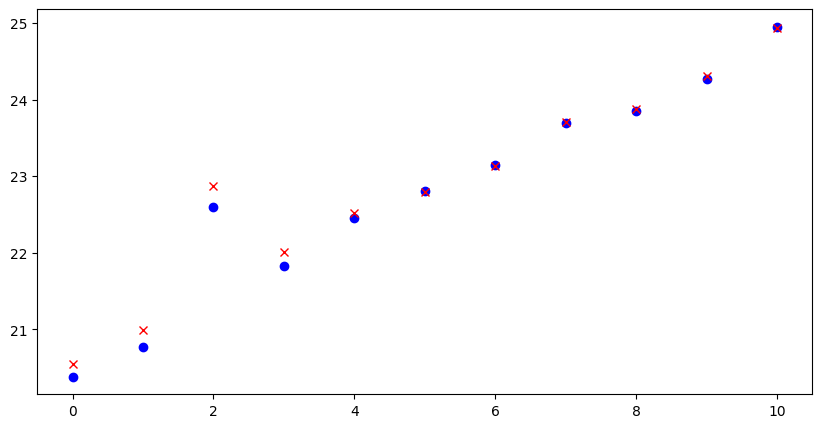

In [33]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(vix_f, 'bo')
plt.plot(fut, 'rx')

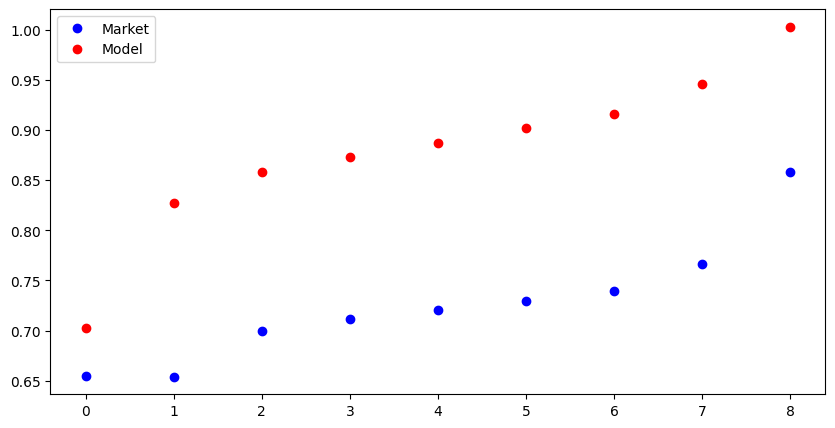

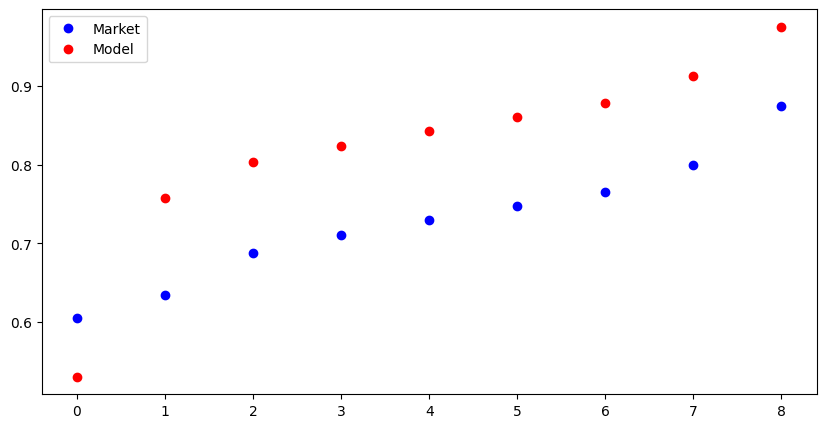

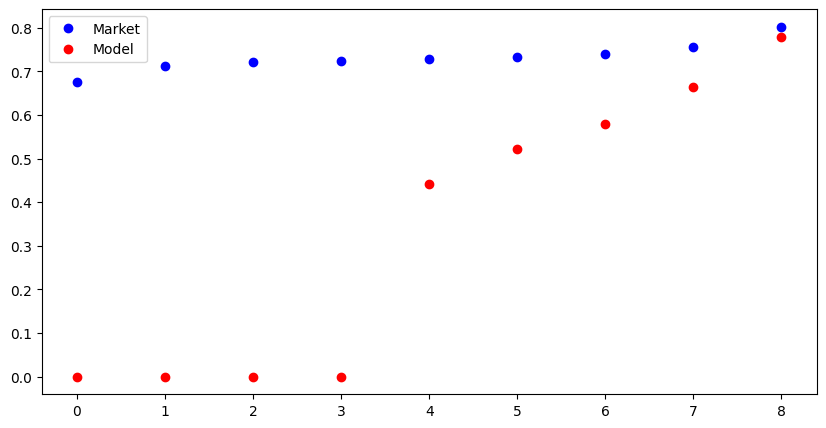

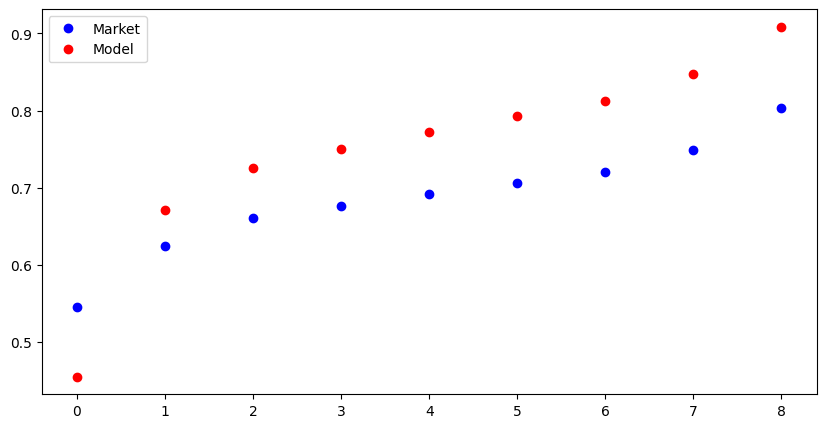

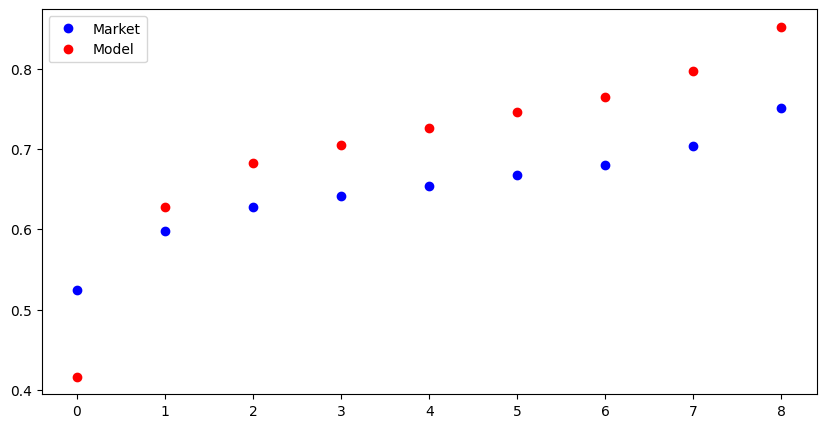

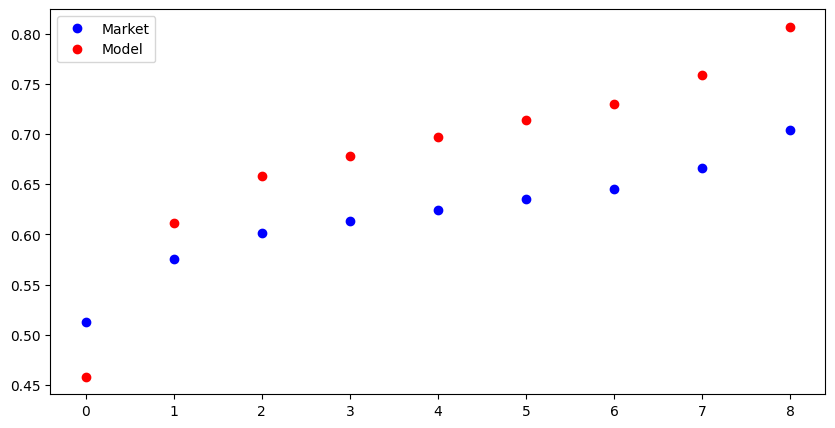

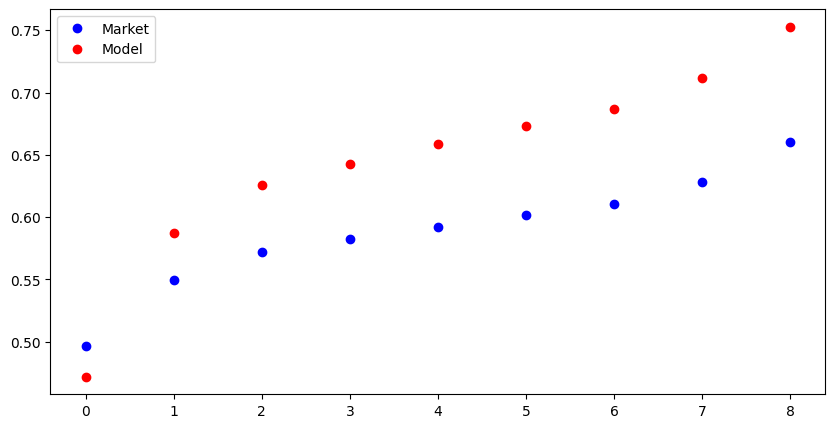

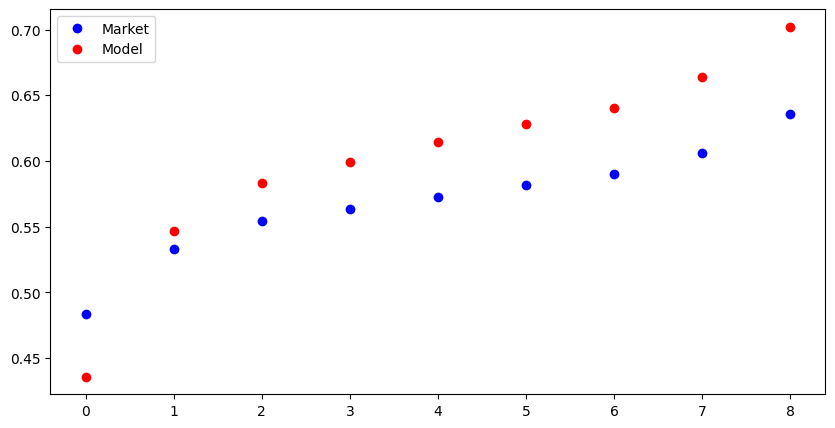

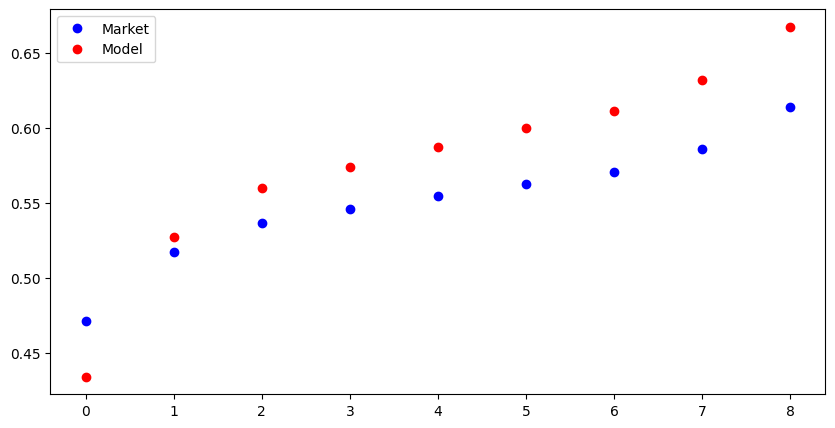

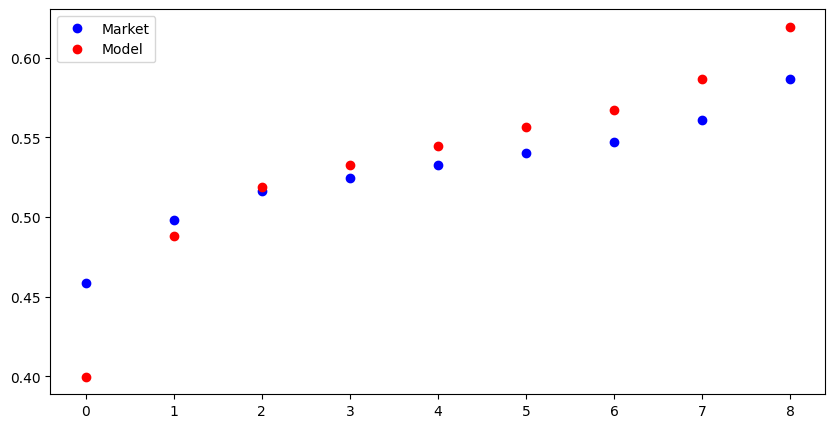

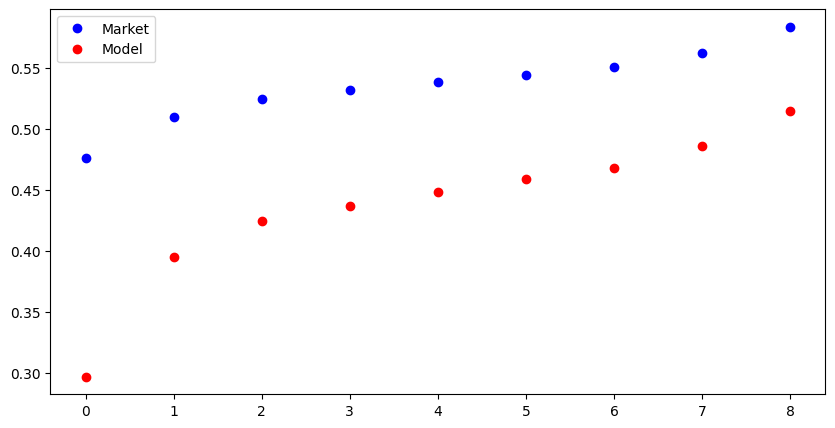

In [34]:
for i in range(nr):
    fig = plt.figure(i)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.plot(IV[i,:], 'bo')
    plt.plot(iv[i,:],'ro')
    plt.legend(["Market","Model"])

In [28]:
df = pd.DataFrame(model_param_global.reshape((1,6)), columns = ["H", "eps", "a0", "a1", "a3", "a5"])
df.to_csv("VIX_param.csv", index = False)